In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/')

from Graph_Helper import load_timesteps
from hierarchy_model import hierarchy_model
from Recent_10_feature_mat import generate_features, generate_features_small
import json
import os

import scipy.sparse as sparse

# Importing data and simulating hierarchy model

In [2]:
# Load Delta as sparse array
nodelist, Delta = load_timesteps(os.path.join(os.pardir, "data", "last_10_graph.npy"))

# Load small subset of covariates
cov = generate_features()
cov_small = generate_features_small()

# Initialize hierarchy object with Delta and cov
model = hierarchy_model(Delta=Delta[-10:], cov=cov[-10:]) 

In [3]:
# Import parameter values
with open(os.path.join(os.pardir, "data", "parameters_large_2.json")) as file:
        parms_large = json.load(file)
        
with open(os.path.join(os.pardir, "data", "parameters_small.json")) as file:
        parms_small = json.load(file)
        
print(f"Beta (Small Model): {parms_small['beta']}")
print(f"Beta (Full Model): {parms_large['beta']}")

Beta (Small Model): [-0.007409432514627407, 0.0036560068991551235, -1.1245365278450626e-07]
Beta (Full Model): [-0.009091430906826212, 0.00949641821645611, -1.7108999566982896e-07, -0.003781894229703389, 0.049316487839977025, -0.008448382945570092, -0.024061054545336164, -0.03316909039832221, 0.023931543652760214, -0.020061095873786145, -0.0011788646938160126, 0.003050194733266819, -0.0010680419357188698, -0.03451110084774202, -0.016127618003437594, 0.0039685439008590884, 0.05992106498459428, 0.010716471010017381]


In [4]:
Gamma = model.simulate(parms_large['beta'], 1, 9)

Features at time 0 computed.
Features at time 1 computed.
Features at time 2 computed.
Features at time 3 computed.
Features at time 4 computed.
Features at time 5 computed.
Features at time 6 computed.
Features at time 7 computed.
Features at time 8 computed.
Features at time 9 computed.


## Plots

In [5]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

#cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
#cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [6]:
## Heler functions 

import numpy as np

def matrix_sort(A, v):
    row_sorted = A[np.argsort(v)]
    col_sorted = row_sorted[:, np.argsort(v)]
    return(col_sorted)	

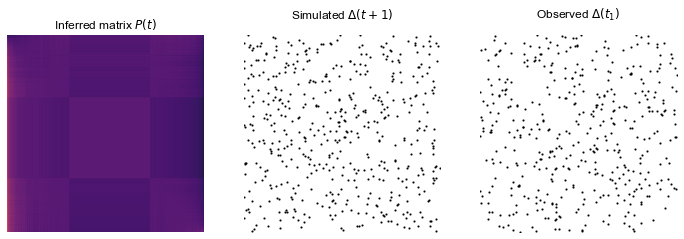

In [7]:
## Matrix Plots

t = 2

## Visualizing Gamma
V = Gamma[t]

ordering = -V.sum(axis = 0)

fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(131)

ax.imshow(matrix_sort(V, ordering), cmap="inferno", alpha=0.95)
ax.set(title = 'Inferred matrix $P(t)$')
plt.gca().axis('off')

## Visualizing Delta

Delta_sim = model.get_Delta_sim()

ax = fig.add_subplot(132)
tmp = matrix_sort(Delta_sim[t], ordering)
ordered_Delta_sim = sparse.csr_matrix(tmp)
ax.spy(ordered_Delta_sim, markersize=1, color = "black")
ax.set(title = 'Simulated $\Delta(t+1)$')
ax.axis('off')

ax = fig.add_subplot(133)
tmp = matrix_sort(Delta[t].toarray(), ordering)
ordered_Delta = sparse.csr_matrix(tmp)
ax.spy(ordered_Delta, markersize=1, color='black')
ax.set(title = 'Observed $\Delta(t_1)$')
ax.axis('off')

plt.savefig("../figures/matrix_plot.png")

## Hierarchical Dynamics

In [8]:
Rank_vec = np.stack( Gamma, axis=0 ).mean(axis=1)

[Text(0.5, 1.0, 'Actor-Director rankings')]

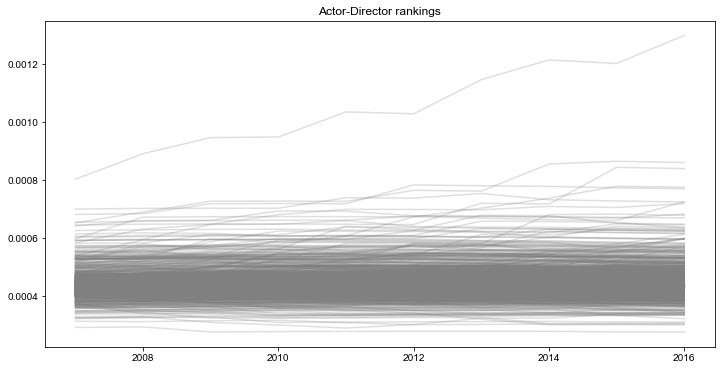

In [9]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
years = [2007 + i for i in range(Rank_vec.shape[0])]
ax.plot(years, Rank_vec, color = 'grey', alpha = .25);
ax.set(title = 'Actor-Director rankings')

In [10]:
# Pull out top five people over all time
Total_Rank = Rank_vec.sum(axis=0)
Top_Set = (-Total_Rank).argsort()[:5]
Bottom_Set = (Total_Rank).argsort()[:5]

In [11]:
# Load in names
import pandas as pd
movie_industry = pd.read_csv("../data/movie_industry.csv", encoding = "ISO-8859-1" )
movie_industry = movie_industry[movie_industry.year >= 2007]
directors2007 = np.unique(movie_industry.director.values)
actors2007 = np.unique(movie_industry.star.values)
    
df = pd.read_csv("../data/features.csv")
condition = (df.agent.isin(directors2007) & (df.is_director == 1)) | (df.agent.isin(actors2007) & (df.is_director == 0))
df = df[condition]
df = df.loc[df.year>=2007]
 
Agent_names_high = df.iloc[Top_Set]['agent'].values
Agent_names_low = df.iloc[Bottom_Set]['agent'].values

In [12]:
years = [2007 + t for t in range(Rank_vec.shape[0])]
Rank_vec_high = np.stack([Rank_vec[t][Top_Set] for t in range(Rank_vec.shape[0])], axis =0)
Rank_vec_low = np.stack([Rank_vec[t][Bottom_Set] for t in range(Rank_vec.shape[0])], axis =0)

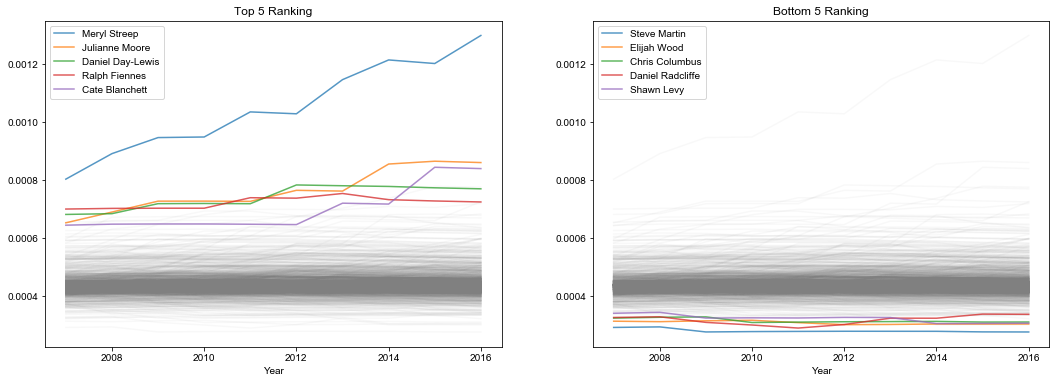

In [13]:
fig = plt.figure(figsize = (18,6))

# Best actors
ax = fig.add_subplot(121)
ax.plot(years, Rank_vec, color = 'grey', alpha = .05);
ax.set(title = 'Actor-Director rankings')

for i in range(len(Top_Set)):
    ax.plot(years, Rank_vec_high[:,i], alpha = 0.75, label = Agent_names_high[i]);

#ax.plot(years, Rank_vec, color = 'brown', label = "Leonardo Dicaprio")
ax.legend()
ax.set_xlabel("Year")
ax.set(title = 'Top 5 Ranking')

# Worst actors

ax = fig.add_subplot(122)
ax.plot(years, Rank_vec, color = 'grey', alpha = .05);
ax.set(title = 'Actor-Director rankings')

for i in range(len(Top_Set)):
    ax.plot(years, Rank_vec_low[:,i], alpha = 0.75, label = Agent_names_low[i]);

ax.legend()
ax.set_xlabel("Year")
ax.set(title = 'Bottom 5 Ranking')

plt.savefig('../figures/rankings.png')

## Printng parameters to table

In [14]:
cov_name = list(df.drop(columns=['agent','is_director','id', 'year','time']).columns)
# Latex Formatting columns

# cov_name = ['\\texttt{' + cov + '}' for cov in cov_name]
cov_name

['log_total_gross',
 'mean_score',
 'mean_votes',
 'Comedy',
 'Drama',
 'Action',
 'Crime',
 'Adventure',
 'Biography',
 'Horror',
 'Animation',
 'R',
 'PG-13',
 'PG',
 'NOT RATED',
 'G',
 'nominations',
 'win_counts']

In [15]:
parms_df = pd.DataFrame({' ': cov_name,

                   'Small Model': parms_small['beta'] + [" "]*(len(parms_large['beta']) - len(parms_small['beta'])),

                   'Full Model': parms_large['beta']})

parms_df.to_latex("../data/parm_table.tex", 
                                     header=True,
                                      index = False,
                                    caption = "Inferred $\\beta$ parameters corresponding to variables above.",
                                     bold_rows=True,
                                    float_format="{:0.2e}".format)

## Are actors more highly ranked than directors?

In [16]:
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
movie_industry = pd.read_csv("../data/movie_industry.csv", encoding = "ISO-8859-1" )
movie_industry = movie_industry[movie_industry.year >= 2007]
directors2007 = np.unique(movie_industry.director.values)
actors2007 = np.unique(movie_industry.star.values)
df = pd.read_csv("../data/features.csv")
condition = (df.agent.isin(directors2007) & (df.is_director == 1)) | (df.agent.isin(actors2007) & (df.is_director == 0))
df = df[condition]
df = df.loc[df.year==2007]
is_director = df.is_director.values

MannwhitneyuResult(statistic=585700.0, pvalue=0.00021639756846319452)

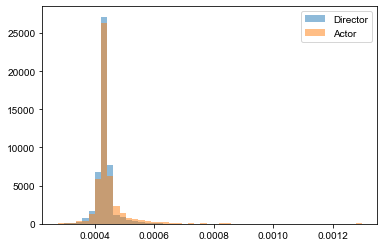

In [17]:
bins = np.linspace(min(Rank_vec[-1]), max(Rank_vec[-1]), 50)
plt.hist(Rank_vec[-1][is_director == 1], density = True, bins = bins, label = "Director", alpha = 0.5)
plt.hist(Rank_vec[-1][is_director == 0], density = True, bins = bins, label = "Actor", alpha = 0.5)
plt.legend()
mannwhitneyu(Rank_vec[-1][is_director == 1],
                      Rank_vec[-1][is_director == 0], alternative = "less")